In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install ipdb
import ipdb
# Use ipdb.set_trace()

In [2]:
# Import statements

import os
import random
import pickle
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyarrow.parquet as pq
import pyarrow as pa

from tqdm import tqdm
from PIL import Image
from io import BytesIO
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize

In [3]:
# Set file paths

os.chdir('/content/gdrive/My Drive/Colab Notebooks/Object Detection on Football Pitches/')

images_path = 'easy-500/images.parquet'
labels_path = 'easy-500/labels.parquet'


In [4]:
# Parameters

ORIG_IMG_WIDTH = 1024
ORIG_IMG_HEIGHT = 512
RESIZED_IMG_WIDTH = 512
RESIZED_IMG_HEIGHT = 256

NUM_LABELS = 8
NUM_CLASSES = 3
GRID_SIZE_WIDTH = 12
GRID_SIZE_HEIGHT = 6
BOUNDING_BOXES_PER_CELL = 2

LAMBDA_COORD = 5
LAMBDA_NOOBJ = 0.5
LAMBDA_ORIENT = 1
LEARNING_RATE = 0.01
EPOCHS = 1
BATCH_SIZE = 8



In [5]:
def create_images_array(parquet_file, image_column):
    # Read the Parquet file
    table = pq.read_table(parquet_file)

    # Extract the id and image data from the specified columns
    image_list = table.column(image_column).to_pylist()

    # Define the transformation pipeline
    transform = transforms.Compose([
        lambda image_data: Image.open(BytesIO(image_data)),  # Load image from bytes
        transforms.Resize((RESIZED_IMG_HEIGHT, RESIZED_IMG_WIDTH)),  # Resize images
        transforms.Lambda(lambda img: np.array(img, dtype=np.float32) / 255.0),  # Convert to NumPy array and normalize
    ])

    # Read images into a NumPy array
    images_array = np.array([transform(image_data) for image_data in image_list])
    images_array = images_array.transpose(0, 3, 1, 2)

    return images_array


# Read images into a numpy array
image_column = 'image'
images_array = create_images_array(images_path, image_column)


In [6]:
def map_groundtruth_to_grid_wrapper(
    df,
    img_width=ORIG_IMG_WIDTH,
    img_height=ORIG_IMG_HEIGHT,
    grid_size_height=GRID_SIZE_HEIGHT,
    grid_size_width=GRID_SIZE_WIDTH,
    bounding_boxes_per_cell=BOUNDING_BOXES_PER_CELL,
    num_labels=NUM_LABELS,
    ):

    # Initialize ground truth array
    ground_truth_array = np.zeros((grid_size_width, grid_size_height, bounding_boxes_per_cell, NUM_LABELS), dtype=np.float32)

    # One-hot encode the class
    df_encoded = pd.get_dummies(df, columns=['class'])

    # Calculate the aspect ratio of the image
    aspect_ratio = img_width / img_height

    for i, row in df_encoded.iterrows():

        # Normalize x and y
        norm_x = row['x'] / img_width
        norm_y = row['y'] / img_height

        # Normalize the radius based on the aspect ratio
        norm_radius = (row["radius"] * aspect_ratio) / max(img_width, img_height)

        # Map orientation to the range [0, 2π]
        orientation = row["orientation"] % (2 * np.pi)

        # Normalize orientation
        norm_orientation = orientation / (2 * np.pi)

        # Determine the responsible grid cell
        cell_x = min(int(norm_x * grid_size_width), grid_size_width - 1)
        cell_y = min(int(norm_y * grid_size_height), grid_size_height - 1)

        # Normalize x and y relative to the cell
        cell_norm_x = (norm_x * grid_size_width) % 1  # Edge case where norm_x=1 ????
        cell_norm_y = (norm_y * grid_size_height) % 1  # Edge case where norm_y=1 ?????

        # Assemble the label data
        label_data = [
            np.float32(cell_norm_x),
            cell_norm_y,
            norm_radius,
            norm_orientation,
            1,
            row["class_0"],
            row["class_1"],
            row["class_2"],
        ]

        # Update ground truth array if there is an empty bounding box
        for bb in range(bounding_boxes_per_cell):
            if np.all(ground_truth_array[cell_x, cell_y, bb] == 0):
                ground_truth_array[cell_x, cell_y, bb] = label_data
                break

    return ground_truth_array


# Apply the map_groundtruth_to_grid_wrapper function to each group
labels_df = pd.read_parquet(labels_path, engine="pyarrow")
grouped_labels_df = labels_df.groupby('image_id')
labels_array = np.stack(grouped_labels_df.apply(lambda group: map_groundtruth_to_grid_wrapper(group)))



def has_negative_values(array):
        mask = array < 0
        return np.any(mask)

try:
    assert has_negative_values(labels_array) == False
except AssertionError:
    print("Assertion failed: labels_array has negative values")

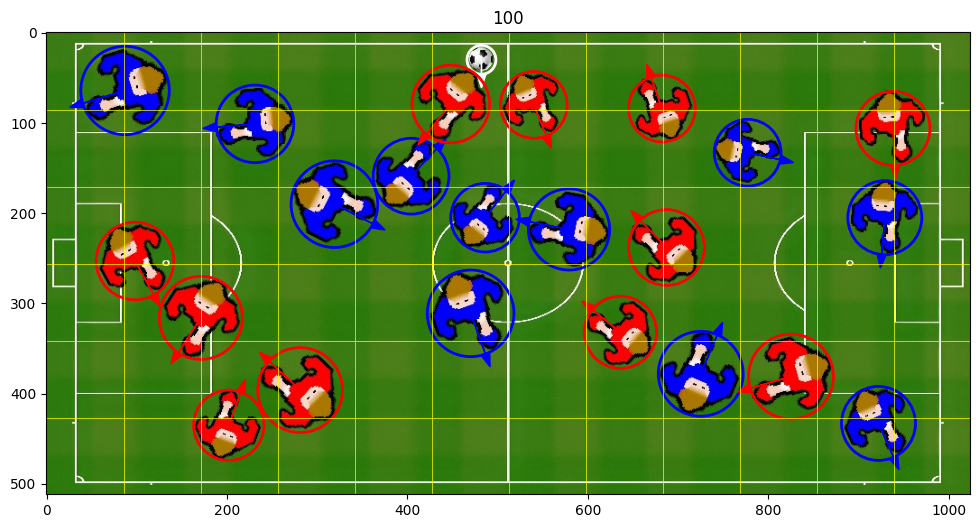

In [22]:
def print_image(image_num, labels):

    # Adjust size of plot
    plt.figure(figsize=(12, 6))

    # Plot selected image from images dictionary
    images_df = pd.read_parquet(images_path, engine="pyarrow")

    binary_image = images_df.loc[image_num, 'image']
    pil_image = Image.open(BytesIO(binary_image))

    # Display the image using matplotlib
    plt.imshow(pil_image)

    # Calculate the dimensions of each grid cell
    cell_width = ORIG_IMG_WIDTH / GRID_SIZE_WIDTH
    cell_height = ORIG_IMG_HEIGHT / GRID_SIZE_HEIGHT
    aspect_ratio = ORIG_IMG_WIDTH / ORIG_IMG_HEIGHT

    # Draw vertical grid lines
    for i in range(1, GRID_SIZE_WIDTH):
        plt.axvline(x=i * cell_width, color='yellow', linestyle='-', linewidth=0.5)

    # Draw horizontal grid lines
    for i in range(1, GRID_SIZE_HEIGHT):
        plt.axhline(y=i * cell_height, color='yellow', linestyle='-', linewidth=0.5)

    # Get the label data for the specified sample
    if len(labels) == 1:
        image_labels = labels[0]
    else:
        image_labels = labels[image_num]
    labels_df = pd.DataFrame(image_labels.reshape(-1, 8))
    pd.set_option('display.max_rows', None)

    # Plot circles
    for x in range(GRID_SIZE_WIDTH):
        for y in range(GRID_SIZE_HEIGHT):
            for i in range(BOUNDING_BOXES_PER_CELL):
                row_index = (x * GRID_SIZE_WIDTH) + (y * BOUNDING_BOXES_PER_CELL) + i
                row = labels_df.iloc[row_index]
                if row[4] != 0:

                    # Extract circle parameters from label_data
                    x_center_norm = row[0]
                    y_center_norm = row[1]
                    radius_norm = row[2]
                    orientation_norm = row[3]

                    if row[5] == 1:
                        object_color = 'white'
                    elif row[6] == 1:
                        object_color = 'blue'
                    else:
                        object_color = 'red'

                   # Reverse the normalisation
                    x_center = (x + x_center_norm) * ORIG_IMG_WIDTH / GRID_SIZE_WIDTH
                    y_center = (y + y_center_norm) * ORIG_IMG_HEIGHT / GRID_SIZE_HEIGHT
                    radius = radius_norm * max(ORIG_IMG_WIDTH, ORIG_IMG_HEIGHT) / aspect_ratio
                    orientation = orientation_norm * 2 * np.pi

                    # Draw circles using Matplotlib
                    circle = plt.Circle((x_center, y_center), radius, color=object_color, fill=False, linewidth=2)
                    plt.gca().add_artist(circle)

                    # Draw arrows

                    # Actual data
                    #dx = np.cos(-orientation) * radius
                    #dy = np.sin(-orientation) * radius

                    # Adjusted data - error in orientation data??!!
                    dx = np.cos(-orientation + np.pi/2) * radius
                    dy = np.sin(-orientation + np.pi/2) * radius
                    plt.arrow(x_center, y_center, dx, dy, color=object_color, linewidth=1, head_width=10, head_length=15)


    plt.title(str(image_num))
    plt.axis("on")
    plt.show()



# Print out an image from the dataset and overlay its label data
image_num = 100
print_image(image_num, labels_array)


In [7]:
# Create datasets for training, validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(
    images_array, labels_array, test_size=0.2, random_state=21
    )
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=33
    )

print(f'Complete dataset - images:{len(images_array)}, labels:{len(labels_array)}')
print(f'Train dataset - images:{len(X_train)}, labels:{len(y_train)}')
print(f'Validation dataset - images:{len(X_val)}, labels:{len(y_val)}')
print(f'Test dataset - images:{len(y_test)}, labels:{len(y_test)}')

# Save datasets to pickle
pickle.dump(X_train,
            open('X_train.pkl', 'wb'))
pickle.dump(X_val,
            open('X_val.pkl', 'wb'))
pickle.dump(X_test,
            open('X_test.pkl', 'wb'))
pickle.dump(y_train,
            open('y_train.pkl', 'wb'))
pickle.dump(y_val,
            open('y_val.pkl', 'wb'))
pickle.dump(y_test,
            open('y_test.pkl', 'wb'))

Complete dataset - images:500, labels:500
Train dataset - images:400, labels:400
Validation dataset - images:67, labels:67
Test dataset - images:33, labels:33


In [69]:
# Load datasets from pickle
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)


In [8]:
# Convert train, validation and test datasets to Tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# Create DataLoader for training dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create DataLoader for validation dataset
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create DataLoader for test dataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


The convolutional layers can be pre-trained, which according to the YOLOv1 paper, gives fast convergence.

In [9]:
class YOLOModelv1(nn.Module):
    def __init__(
        self,
        grid_size_height=GRID_SIZE_HEIGHT,
        grid_size_width=GRID_SIZE_WIDTH,
        bounding_boxes_per_cell=BOUNDING_BOXES_PER_CELL,
        num_classes=NUM_CLASSES,
        num_labels=NUM_LABELS,
        img_width=RESIZED_IMG_WIDTH,
        img_height=RESIZED_IMG_HEIGHT,
        ):

        super(YOLOModelv1, self).__init__()
        self.grid_size_height = grid_size_height
        self.grid_size_width = grid_size_width
        self.bounding_boxes_per_cell = bounding_boxes_per_cell
        self.num_classes = num_classes
        self.num_labels = num_labels
        self.img_width = img_width
        self.img_height = img_height

        # Define a simple set of convolutional layers
        self.conv_layers = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten()
        )

        # Dynamically calculate the input size of the fully connected layers
        # based on the output shape of the last convolutional layer
        fc_input_size = self._get_conv_output_shape()

        # Output layer structure
        num_coordinates = 2  # x, y coordinates
        num_radius = 1       # radius
        num_orientation = 1  # orientation
        obj_confidence = 1   # confidence of the prescence of an object
        num_classes = 3      # one-hot encoded class (0=ball, 1=team1, 2=team2)
        output_neurons = num_coordinates + num_radius + num_orientation + obj_confidence + num_classes

        # Define the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(fc_input_size, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(512, grid_size_height * grid_size_width * bounding_boxes_per_cell * output_neurons)

        )

    def print_layer_shapes(self, x):
        print("\n********\nInput shape:", x.shape)
        x = self.conv_layers(x)
        print("Convolutional layers output shape:", x.shape)
        x = self.fc_layers[:2](x)  # Pass through the first two layers of fc_layers
        print("Flattened output shape:", x.shape)
        x = self.fc_layers[2:](x)  # Pass through the rest of the fc_layers
        print("Final output shape:", x.shape)


    def forward(self, x):
        x = self.conv_layers(x)
        output = self.fc_layers(x)

        # Apply activation functions to output layer
        units_coordinate = units_radius = units_orientation = units_confidence = self.grid_size_width * self.grid_size_height * self.bounding_boxes_per_cell
        units_classes = self.grid_size_width * self.grid_size_height * self.bounding_boxes_per_cell * self.num_classes
        x, y, radius, orientation, confidence, class_labels = torch.split(output, [units_coordinate, units_coordinate, units_radius, units_orientation, units_confidence, units_classes], dim=1)

        # Get batch size
        current_batch_size = x.size(0)

        # Apply linear activation functions to x, y and radius
        pred_x = F.leaky_relu(x, negative_slope=0.1)
        pred_y = F.leaky_relu(y, negative_slope=0.1)
        pred_radius = F.leaky_relu(radius, negative_slope=0.1)

        # Apply hyperbolic tangent function then scale to range [-pi/2, pi/2]
        pred_orientation = torch.tanh(orientation) * (np.pi / 2)

        # Apply sigmoid activation to confidence labels
        pred_confidence = torch.sigmoid(confidence)

        # Apply softmax activation to class labels
        # Do I need to do this? F.cross_entropy in loss function computes softmax internally?
        class_labels_reshaped = torch.reshape(class_labels, (1, -1, 3))
        pred_class = torch.nn.functional.softmax(class_labels_reshaped, dim=-1)

        # Reassembling and reshaping the output tensor for comparison with the ground truth
        pred_x = pred_x.reshape(current_batch_size, self.grid_size_width, self.grid_size_height, self.bounding_boxes_per_cell)
        pred_y = pred_y.reshape(current_batch_size, self.grid_size_width, self.grid_size_height, self.bounding_boxes_per_cell)
        pred_radius = pred_radius.reshape(current_batch_size, self.grid_size_width, self.grid_size_height, self.bounding_boxes_per_cell)
        pred_orientation = pred_orientation.reshape(current_batch_size, self.grid_size_width, self.grid_size_height, self.bounding_boxes_per_cell)
        pred_confidence = pred_confidence.reshape(current_batch_size, self.grid_size_width, self.grid_size_height, self.bounding_boxes_per_cell)

        xyrop_concat = torch.stack([pred_x, pred_y, pred_radius, pred_orientation, pred_confidence], dim=-1)

        xyrop_reshaped = torch.reshape(xyrop_concat, (current_batch_size, self.grid_size_width, self.grid_size_height, self.bounding_boxes_per_cell, 5))
        pred_class_reshaped = torch.reshape(pred_class, (current_batch_size, self.grid_size_width, self.grid_size_height, self.bounding_boxes_per_cell, 3))

        pred_reshaped = torch.cat((xyrop_reshaped, pred_class_reshaped), dim=-1)

        return pred_reshaped


    def _get_conv_output_shape(self):
        # Calculate the output shape of the convolutional layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, self.img_height, self.img_width)  # Assuming shape of input
            conv_output = self.conv_layers(dummy_input)
        return conv_output.size(1)


There are several ways to compare predicted BBs with target BBs.
1. Compare both Predicted BBs with the one Target BB (but inflexible where > 1 object per BB)
1. As there is only 1 target BB, choose the best predicted BB (using IoU) and calculate the loss using that pair.
1. Compare Target BB1 with Prediction BB1, and Target BB2 with Prediction BB2 (even though Target 1 BB2 is zeros - i.e. no second object).
1. As for 1, match Target BB1 with the best prediction and the match the other prediction with Target BB2 (no object).

I have chosen to implement method 3.


Build up implementation of the loss function 1 element at a time.

Look into using sum or mean in the loss function
How to balance the importance of different terms in the loss function?



In [60]:
class YOLOLossv1(nn.Module):
    def __init__(
        self,
        grid_size_height=GRID_SIZE_HEIGHT,
        grid_size_width=GRID_SIZE_WIDTH,
        bounding_boxes_per_cell=BOUNDING_BOXES_PER_CELL,
        num_classes=NUM_CLASSES,
        ):

        super(YOLOLossv1, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.grid_size_height = grid_size_height
        self.grid_size_width = grid_size_width
        self.bounding_boxes_per_cell = bounding_boxes_per_cell
        self.num_classes = num_classes


    def compute_box_loss(self, bbox_preds, bbox_targets):
        """
        Compute the loss for the bounding box predictions
        """
        '''
        # Extract the x, y, w, h components from the predictions and targets
        bbox_preds = bbox_preds.reshape(-1, 4)
        bbox_targets = bbox_targets.reshape(-1, 4)

        # Compute the loss using MSE for the x, y, w, h components
        bbox_loss = self.mse(bbox_preds[:, :2], bbox_targets[:, :2]) + \
                    self.mse(torch.sqrt(bbox_preds[:, 2:4]), torch.sqrt(bbox_targets[:, 2:4]))

        return bbox_loss
        '''
        return 1.


    def compute_obj_loss(self, obj_preds, obj_targets):
        """
        Compute the loss for the object confidence predictions
        """
        batch_size = obj_targets.size(0)
        total_bounding_boxes = obj_targets.size(1)

        # Flatten the object confidence predictions and targets
        obj_preds = obj_preds.reshape(-1)
        obj_targets = obj_targets.reshape(-1)

        # Compute the loss using Binary Cross-Entropy
        obj_loss = F.binary_cross_entropy(obj_preds, obj_targets, reduction="none")

        return obj_loss


    def compute_class_loss(self, class_preds, class_targets):
        """
        Compute the loss for the class probability predictions
        """
        batch_size = class_targets.size(0)
        total_bounding_boxes = class_targets.size(1)

        # Flatten the class probability predictions and targets
        class_preds = class_preds.view(-1, self.num_classes)
        class_targets = class_targets.view(-1, self.num_classes)

        # Compute the loss using Cross-Entropy
        class_loss = F.cross_entropy(class_preds, class_targets, reduction="none")

        # Reshape loss tensor
        class_loss = class_loss.view(-1, total_bounding_boxes, 1)

        return class_loss


    def unpack_tensors(self, input_tensor):
        batch_size = input_tensor.size(0)
        total_bounding_boxes = input_tensor.size(1) * input_tensor.size(2) * input_tensor.size(3)

        box_values = input_tensor[:, :, :, :, :4].reshape(batch_size, total_bounding_boxes, 4)
        obj_values = input_tensor[:, :, :, :, 4].reshape(batch_size, total_bounding_boxes, 1)
        class_values = input_tensor[:, :, :, :, 5:].reshape(batch_size, total_bounding_boxes, 3)

        return box_values, obj_values, class_values


    # Function to calculate IoU between two bounding circles
    def iou_pairs(self, bounding_circle1, bounding_circle2):
        x1, y1, r1, *_ = bounding_circle1
        x2, y2, r2, *_ = bounding_circle2
        dist_centers = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
        r_sum = r1 + r2
        if dist_centers >= r_sum:
            return 0.0
        r_min = min(r1, r2)
        r_max = max(r1, r2)
        if dist_centers + r_min <= r_max:
            return 1.0
        return (r_min + dist_centers - r_max) / (2 * r_min + dist_centers - r_max)


    # Function to process batch of predictions and targets and swap predictions if necessary
    def iou(self, predictions, targets):
        grid_cells = predictions.size(0)
        for i in range(grid_cells):
            prediction_pair = predictions[i]
            target_pair = targets[i]
            iou_1 = self.iou_pairs(prediction_pair[0], target_pair[0])
            iou_2 = self.iou_pairs(prediction_pair[1], target_pair[0])
            if iou_2 > iou_1:
                predictions[i] = predictions[i][[1, 0]]
        return predictions


    def forward(self, predictions, targets):

        # Compare bounding circles of predictions with targets
        batch_size = predictions.size(0)
        bb_preds = predictions.view(batch_size * predictions.size(1) * predictions.size(2), 2, 8)
        bb_targets = targets.view(batch_size * targets.size(1) * targets.size(2), 2, 8)

        bb_preds_iou = self.iou(bb_preds, bb_targets)

        predictions = bb_preds_iou.view(batch_size, 12, 6, 2, 8)
        targets = bb_targets.view(batch_size, 12, 6, 2, 8)


        # Unpack the predictions and targets
        box_preds, obj_preds, class_preds = self.unpack_tensors(predictions)
        box_targets, obj_targets, class_targets = self.unpack_tensors(targets)
        batch_size = class_targets.size(0)

        # Compute the individual loss components
        box_loss = self.compute_box_loss(box_preds, box_targets)
        obj_loss = (self.compute_obj_loss(obj_preds, obj_targets))
        class_loss = (self.compute_class_loss(class_preds, class_targets) * obj_targets)

        box_loss = radius_loss = orient_loss = 0  # REMOVE!!!

        total_loss = (LAMBDA_COORD * obj_targets * box_loss
                     + LAMBDA_COORD * obj_targets * radius_loss
                     + LAMBDA_ORIENT * obj_targets * orient_loss
                     + obj_targets * obj_loss
                     + LAMBDA_NOOBJ * (1 - obj_targets) * obj_loss
                     + obj_targets * class_loss)


        return total_loss.sum() / batch_size


In [61]:
# Define the model
model = YOLOModelv1()
print(model)

# Define the loss function
loss_fn = YOLOLossv1()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)


YOLOModelv1(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Linear(in_fea

Is the model over-fitting? Do I need to add soem regularization term (some function of B)?



In [ ]:
# Training loop
train_loss_hist = []

for epoch in tqdm(range(EPOCHS)):
    train_loss = 0.

    tmp_batch_count = 0

    for batch_idx, (images, labels) in enumerate(train_dataloader):

        if tmp_batch_count == 100: break

        # Forward pass
        outputs = model.forward(images)
        # Compute loss
        loss = loss_fn(outputs, labels)
        # Zero the gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Update model parameters
        optimizer.step()

        # Compute statistics or metrics
        train_loss += loss

        # Print loss for monitoring training progress
        print(f"\nEpoch {epoch + 1} Batch {batch_idx + 1} Loss: {loss:.4f}")

        tmp_batch_count += 1


    # Compute average statistics or metrics for the epoch
    avg_train_loss = train_loss / tmp_batch_count  # THIS LINE IS FOR TESTING
    #avg_train_loss = train_loss / len(train_dataloader)  # RESTORE THIS LINE OF CODE


    # Log the epoch's training loss
    train_loss_hist.append(avg_train_loss)

    # Print or log statistics or metrics for the epoch
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss}")


In [ ]:
# Load saved model and the images array

# Print out an image from the dataset and overlay the model's prediction
image_num = 0

image = images_array[image_num:image_num+1]
image_tensor = torch.tensor(image)

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    pred = model(image_tensor)

print_image(image_num, pred)

Can I output a grid that shows the class probability map for each of the 12 x 6 grid cells? Different colour for each class.

Use visualize_features(features) to see what each channel is picking up on each convolution.